In [76]:
#!/usr/bin/python

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_recall_fscore_support

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

%matplotlib inline

### Task 1: Select what features to use

In [77]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Get all values at first
features_list = ['poi','salary','to_messages','deferral_payments',
                  'total_payments','exercised_stock_options',
                  'bonus','restricted_stock','shared_receipt_with_poi',
                  'restricted_stock_deferred','total_stock_value',
                  'expenses','loan_advances','from_messages',
                  'other','from_this_person_to_poi',
                  'director_fees', 'deferred_income','long_term_incentive',
                  'from_poi_to_this_person']

### Extract features and labels from dataset and have a closer look
data = featureFormat(data_dict, features_list, remove_NaN = True, remove_all_zeroes = True, sort_keys = False)
labels, features = targetFeatureSplit(data)

In [78]:
### Look at data
print "Data type: "+ str(type(data))
print "Shape: "+ str(data.shape)
print "Number of persons: "+ str(len(labels))
print "Number of features: " + str(features[0].size)

Data type: <type 'numpy.ndarray'>
Shape: (145L, 20L)
Number of persons: 145
Number of features: 19


In [79]:
### Have a look at the number of zeros for each feature
### Feature 1 is POI
### Notice how for example Feature 11 is almost exclusively zeros
for feat_num in range(2,len(data[0])):
    feat_val = []
    for i in data:
        feat_val.append(i[feat_num])
    print "Feature " + str(feat_num-1) + " has " + str(feat_val.count(0)) + " zeroes"

Feature 1 has 59 zeroes
Feature 2 has 106 zeroes
Feature 3 has 20 zeroes
Feature 4 has 43 zeroes
Feature 5 has 63 zeroes
Feature 6 has 35 zeroes
Feature 7 has 59 zeroes
Feature 8 has 127 zeroes
Feature 9 has 19 zeroes
Feature 10 has 50 zeroes
Feature 11 has 141 zeroes
Feature 12 has 59 zeroes
Feature 13 has 52 zeroes
Feature 14 has 79 zeroes
Feature 15 has 128 zeroes
Feature 16 has 96 zeroes
Feature 17 has 79 zeroes
Feature 18 has 71 zeroes


### Task 2: Remove outliers

In [80]:

### From the lessons and further investigation it's clear that there are certain values not representing people, 
### so these are removed.

del data_dict['TOTAL']
del data_dict['THE TRAVEL AGENCY IN THE PARK']
del data_dict['LOCKHART EUGENE E']
data = featureFormat(data_dict, features_list, remove_NaN = True, remove_all_zeroes = True, sort_keys = False)
labels, features = targetFeatureSplit(data)

### Task 3: Create new feature(s)

In [81]:
### First, let look at which features have a high correlation

### Since most zeros are just replaced N/A, we'll get really high correlations
### if we don't remove zero values. We'll remove them instead

### Function takes two vectors of equal length, 
### and returns correlation of all non-zero pairs, and the number of non-zero pairs
def corr_no_zeros(x,y):
    arr = np.column_stack((x,y))
    
    #Make sure both values are not zero
    mask = (arr[:,0] != 0) & (arr[:,1] != 0)
    
    #Find the correlation between the remaining vector
    np.corrcoef(arr[mask].T)[0,1]
    
    return np.corrcoef(arr[mask].T)[0,1], len(arr[mask])

#Check correlation between all features and store in array
corr_arr = np.zeros((0,4))

for i in range(1, len(data[0])-1):
    for j in range(i+1, len(data[0])):
        cnz = corr_no_zeros(data[:,i],data[:,j])
        corr_arr = np.append(corr_arr,np.array([cnz[0],cnz[1],i,j]).reshape((1,4)),axis = 0)

#Sort result so we can inspect good options for PCA
first_row_sort_idx = corr_arr.argsort(axis = 0)[:,1]

#Flip around
corr_arr = corr_arr[first_row_sort_idx][::-1]


#Inspect
print "Correlation - Remaining Rows - Feature # - Feature #"
for i in range(0,25):
    print corr_arr[i,:]

Correlation - Remaining Rows - Feature # - Feature #
[   0.66816639  107.            4.           10.        ]
[   0.85524974  106.            7.           10.        ]
[   0.96356024  100.            5.           10.        ]
[  0.59572806  94.           4.           7.        ]
[  0.57926021  94.           1.           4.        ]
[  0.10979754  94.           4.          11.        ]
[  0.82558889  91.           4.          14.        ]
[  0.61473599  90.           1.          10.        ]
[  0.60690255  88.           1.          14.        ]
[  0.23085549  86.           8.          13.        ]
[  0.4754499  86.          2.         13.       ]
[  0.59168974  86.           4.           5.        ]
[  0.62717087  86.          10.          14.        ]
[  0.55082368  86.           1.           7.        ]
[  0.84799001  86.           2.           8.        ]
[  0.64435737  84.           7.          14.        ]
[  3.47072522e-02   8.40000000e+01   1.00000000e+01   1.10000000e+01]
[  0.

In [82]:
### Looking at the results from above, 4,7 and 5 all correlate strongly with 10
### as wel as mostly non-zero for both values
### We'll have a look at those
print features_list[4]
print features_list[5]
print features_list[7]
print features_list[10]

### Looking at what these represent, it's obvious why (they sum up to 10)
### instead of doing a PCA, an option is to remove 10 from the dataset

total_payments
exercised_stock_options
restricted_stock
total_stock_value


In [83]:
### 14 and 4 have a correlation of 0.82 with many non-zero values.
print features_list[4]
print features_list[14]

total_payments
other


[[ 1.          0.83010504]
 [ 0.83010504  1.        ]]


(-20000, 6000000)

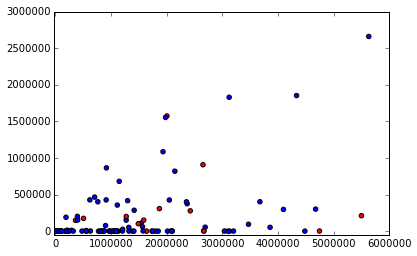

In [84]:
xidx = 4
yidx = 14

plt.scatter(data[:,xidx],data[:,yidx],c = ['b' if x == 0 else 'r' for x in labels ])

print np.corrcoef(data[:,xidx],data[:,yidx])

plt.ylim([-50000,3000000])
plt.xlim([-20000,6000000])

In [85]:
### Combine 'other' and 'total_payments'
from sklearn.decomposition import PCA

X = np.column_stack((data[:,1],data[:,14]))

pca = PCA(n_components=1)
new_feature = pca.fit_transform(X)

#Add the new computed vector at the end of the data matrix
data_with_pca = np.c_[data,new_feature]
print data_with_pca.shape

(143L, 21L)


###Part 4: Try some classifiers

In [100]:
#Function to quickly test out some different classifiers
def test_classifier(clf_in, clf_name, params_in, features, labels):

    skb = SelectKBest()
    #pca = PCA()
    clf = clf_in


    pipe = Pipeline(steps=[("SKB", skb), (clf_name, clf)]) #("PCA",pca),

    kbest_params = {"SKB__k": [8,10,12]}

    #pca_params = {"PCA__n_components": range(4,9)}

    #kbest_params.update(pca_params) 
    kbest_params.update(params_in)
    
    number_of_splits = 20
    cv = StratifiedShuffleSplit(labels, number_of_splits, random_state = 16)

    gs = grid_search.GridSearchCV(pipe,kbest_params,cv = cv, scoring = 'f1')
    gs.fit(features,labels)

    clf = gs.best_estimator_
    prec = 0
    rec = 0
    sc = 0
    for train,test in cv:
        X_train = [features[i] for i in train]
        Y_train = [labels[j] for j in train]

        X_test = [features[i] for i in test]
        Y_test = [labels[j] for j in test]

        clf.fit(X_train,Y_train)

        precision,recall,_,_ = precision_recall_fscore_support(clf.predict(X_test),Y_test,average = 'binary')
        prec = prec + precision
        rec = rec + recall
        sc = sc + clf.score(X_test,Y_test)

    print "Best parameters", gs.best_params_
    print "Score: " ,sc/number_of_splits
    print "Precision: ", prec/number_of_splits
    print "Recall: ", rec/number_of_splits
    print ""
    
    return gs

In [101]:
#Prepare data 
labels_w_pca, features_w_pca = targetFeatureSplit(data_with_pca)

clf_dt = tree.DecisionTreeClassifier()
dt_params = {"DecisionTreeClassifier__min_samples_leaf": [2,4,6],
             "DecisionTreeClassifier__min_samples_split": [4,6,12],
             "DecisionTreeClassifier__min_weight_fraction_leaf": [0,0.02],
             "DecisionTreeClassifier__criterion": ["gini", "entropy"],
             "DecisionTreeClassifier__max_features": ["auto"],
             "DecisionTreeClassifier__max_leaf_nodes": [None,2,5],
             "DecisionTreeClassifier__random_state": [12]}

clf_rf = RandomForestClassifier()
rf_params = {"RF__n_estimators":[5,10,50,200],
              "RF__criterion": ["gini","entropy"],
              "RF__max_features": [3,5,8],
              "RF__random_state": [12]}

print "First out is decision tree"
gs = test_classifier(clf_dt, "DecisionTreeClassifier", dt_params,features_w_pca,labels_w_pca)

print "\nThen comes Random Forest"
gs = test_classifier(clf_rf, "RF", rf_params,features_w_pca,labels_w_pca)

First out is decision tree
Best parameters {'DecisionTreeClassifier__min_samples_leaf': 4, 'DecisionTreeClassifier__random_state': 12, 'DecisionTreeClassifier__max_leaf_nodes': 5, 'SKB__k': 10, 'DecisionTreeClassifier__min_weight_fraction_leaf': 0, 'DecisionTreeClassifier__min_samples_split': 4, 'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_features': 'auto'}
Score:  0.853333333333
Precision:  0.325
Recall:  0.425


Then comes Random Forest
Best parameters {'RF__criterion': 'gini', 'SKB__k': 8, 'RF__n_estimators': 5, 'RF__max_features': 3, 'RF__random_state': 12}
Score:  0.836666666667
Precision:  0.25
Recall:  0.3375



### Task 5: Tune your classifier to achieve better than .3 precision and recall 

In [96]:
#Prepare data
labels, features = targetFeatureSplit(data)

skb = SelectKBest(k = 12)
features_skb = skb.fit_transform(features,labels)

In [ ]:
clf_dt = tree.DecisionTreeClassifier()
dt_params = {"min_samples_leaf": [2,3,4,6],
             "min_samples_split": [4,6,8],
             "min_weight_fraction_leaf": [0,0.01,0.02],
             "criterion": ["gini", "entropy"],
             "max_features": ["auto"],
             "max_leaf_nodes": [None,2,3,5],
             "random_state": [12]}
    
number_of_splits = 300
cv = StratifiedShuffleSplit(labels, number_of_splits, random_state = 16)

gs = grid_search.GridSearchCV(clf_dt,dt_params,cv = cv, scoring = 'f1')
gs.fit(features_skb,labels)

clf = gs.best_estimator_
prec = 0
rec = 0
sc = 0
for train,test in cv:
    X_train = [features[i] for i in train]
    Y_train = [labels[j] for j in train]

    X_test = [features[i] for i in test]
    Y_test = [labels[j] for j in test]

    clf.fit(X_train,Y_train)

    precision,recall,_,_ = precision_recall_fscore_support(clf.predict(X_test),Y_test,average = 'binary')
    prec = prec + precision
    rec = rec + recall
    sc = sc + clf.score(X_test,Y_test)

print "Best parameters", gs.best_params_
print "Score: " ,sc/number_of_splits
print "Precision: ", prec/number_of_splits
print "Recall: ", rec/number_of_splits
print ""

In [107]:
#Create the feature_list
features_list_skb =  [i for (i, v) in zip(features_list[1:], skb.get_support()) if v]
features_list_skb.insert(0,'poi')
print features_list_skb

['poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'loan_advances', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


In [108]:
### Pass in the data_dict with 'TOTAL' removed
my_dataset = data_dict

### Dump it
dump_classifier_and_data(clf, my_dataset, features_list_skb)